In [1]:
using ForwardDiff, NNlib, JLD2
const FD = ForwardDiff;

numType = Float32;

# Define a simple feed-forward neural network:

nnLayer(x,W,b,σ) = σ.(reshape(W,(size(b,1),:))*x .+ b)

function getRandomParams(layerStructure,σ)
    """
    Given a layer structure, generate random neural network parameters
    """
    nParams = sum(X[1][1]*X[1][2]+X[1][2] for X in layerStructure);
    return σ*randn(numType,nParams)
end

function neuralNet(x,layerStructure::Vector{Tuple{Pair{Int64, Int64}, Function}},params)
    """
    Compile a layer structure and evaluate on data point(s)
    """
    X = x;
    n = 1;
    for (layer, σ) in layerStructure
        X = nnLayer(X,params[n:(n-1+layer[1]*layer[2])],params[(n+layer[1]*layer[2]) : (n-1+layer[1]*layer[2]+layer[2])],σ)
        n += layer[1]*layer[2]+layer[2];
    end
    return X
end

layerStructure = [
    (2 => 20,NNlib.σ),
    (20 => 20,NNlib.σ),
    (20 => 1,identity)
];

# Initialize a network

ϕmodel(xt,params) = neuralNet(xt,layerStructure,params);
initParams = getRandomParams(layerStructure,0.1);

@info "Neural network intialized"


# Define boundary and collocation points:

xmin = 0; xmax = 1; Tmax = 1;
V(x) = 0;
# nCollocationPts = 500;
nxCollocationPts = 20;
nyCollocationPts = 20;
nCollocationPts = nxCollocationPts * nyCollocationPts;
n∂t0ptscenter = 50;
n∂t0ptsedges = 20;
n∂t0pts=n∂t0ptscenter+n∂t0ptsedges;
# n∂t0pts = 200;
n∂xptsedges = 30;
n∂xptscenter = 50;
n∂xpts = n∂xptsedges + n∂xptscenter;
collocationPts = hcat(reshape(collect.(Iterators.product(range(0,xmax,nxCollocationPts), range(0,xmax,nyCollocationPts))),:)...) |> Matrix{numType};
∂t0pts = hcat(hcat(reshape(collect.(Iterators.product(range(0,xmax,n∂t0ptsedges), 0:0)),:)...),hcat(reshape(collect.(Iterators.product(range(xmax/2 - 0.08,xmax/2 + 0.08,n∂t0ptscenter), 0:0)),:)...)) |> Matrix{numType}
∂xpts = hcat(hcat(reshape(collect.(Iterators.product(0:1, range(Tmax/2 - 0.075,Tmax/2 + 0.075,n∂xptscenter))),:)...),hcat(reshape(collect.(Iterators.product(0:1, range(0,xmax,n∂xptsedges))),:)...))  |> Matrix{numType};
σinit = 0.025;
ϕt0 = (xt -> exp(-(xt[1] - xmax/2)^2/(2*σinit^2))).(eachcol(∂t0pts)) |> Vector{numType};
dϕt0 = (xt -> 0).(eachcol(∂t0pts)) |> Vector{numType};
ϕx0 = zeros(2n∂xpts) |> Vector{numType};

# Define loss function:


┌ Info: Neural network intialized
└ @ Main In[1]:42


In [3]:
loaded_params = jldopen("wave_eq_NN_params-split.jld2")["params"];


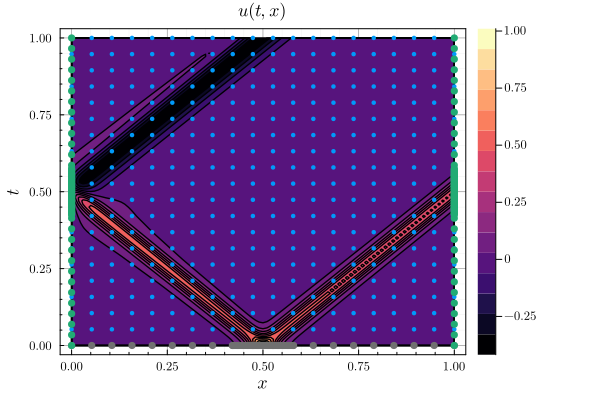

In [31]:
using Plots, PlotThemes, LaTeXStrings; theme(:dao)

let xs = 0:0.01:1, ts = 0:0.01:Tmax
    vals = reshape([ϕmodel([x, t], loaded_params)[1] for x in xs for t in ts],(length(xs),length(ts)));
    plot(ts,xs,vals,linetype=:contourf,title=L"u(t,x)")
    scatter!(eachrow(collocationPts)...,label=:none,markersize=2.5)
    scatter!(eachrow(∂t0pts)...,label=:none,markersize=4)
    scatter!(eachrow(∂xpts)...,label=:none,markersize=4)
    plot!(xlabel=L"x",ylabel=L"t")
end
# savefig("custom_wave_eq_contour.pdf")

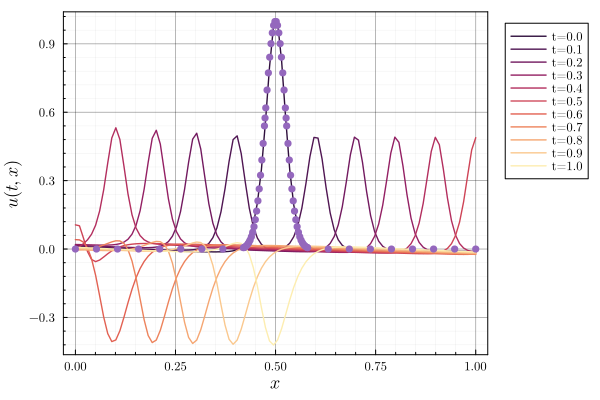

In [34]:
using ColorSchemes
plot()
for t in 0:0.1:Tmax
    pltpts = (collect∘transpose∘hcat)(xmax*range(0,1,100),t*ones(100));
#     plot!(pltpts[1,:],vec(ϕmodel(pltpts, initParams)))
    # plot!(pltpts[1,:],vec(ϕmodel(pltpts, sol.u)),label=:none)
    plot!(pltpts[1,:],vec(ϕmodel(pltpts, loaded_params)),label="t=$t",linecolor=ColorSchemes.matter[256-(Int∘floor)(255*t)])
end
scatter!(∂t0pts[1,:],ϕt0,label=:none)
plot!(xlabel=L"x",ylabel=L"u(t,x)")
# savefig("custom_wave_eq_x.pdf")
